In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from s3fs import S3FileSystem
from IPython.display import clear_output
from secret_values import S3_BUCKET_NAME

In [2]:
sns.set_theme(style="darkgrid")

s3 = S3FileSystem()
bucket_name = S3_BUCKET_NAME

In [3]:
# Función encargada de conectarse al bucket de S3 y devolver los ultimos 50
# datos ordenados por orden de modificación, de esta manera se podra tener
# una linea del tiempo secuencial.
def get_data_from_s3():
    file_list = s3.ls(bucket_name, refresh=True)
    content_list = []

    # Se obtiene la fecha de modificación de cada archivo
    modification_times = [s3.info(file_path).get('LastModified') for file_path in file_list]

    # Se ordenas los archivos por fecha de modificación y se guardan los ultimos 50.
    sorted_files = [file_path for _, file_path in sorted(zip(modification_times, file_list))]
    sorted_files_last_50 = sorted_files[-50:]

    # Se leen y guardan los datos de los últimos 50 archivos en una lista.
    for file_path in sorted_files_last_50:
        with s3.open(file_path, 'r') as file:
            content = file.read()
        content_dict = json.loads(content)
        content_list.append(content_dict)

    return content_list

In [4]:
# Función encargada de generar y mostrar una linea del tiempo de los 
# últimos 50 datos registrados en S3.
def show_time_series(name):
    content_list = get_data_from_s3()
    index = [i+1 for i in range(len(content_list))]

    # Se crea una lista de valores CloseUSD a graficar.
    close_values = [content_dict['CloseUSD'] for content_dict in content_list]

    # Creación y configuración del gráfico
    plt.plot(index, close_values, marker='o', linestyle='-', color='#6495ED', linewidth=2)
    plt.ylabel('Valor de cierre en dólares')
    plt.title(name)
    plt.grid(True, linestyle='--', alpha=0.5)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)

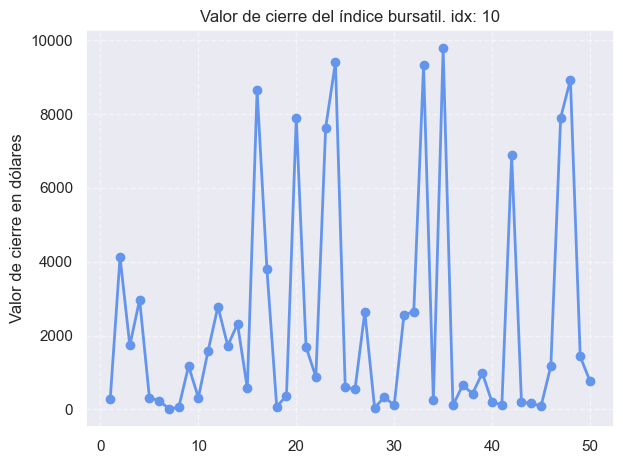

In [5]:
# Se va actualizando la serie de tiempo por N iteraciones.
# Un bucle infinito podria representar una simulación más real.
for i in range(10):
    name = 'Valor de cierre del índice bursatil. idx: ' + str(i+1)
    show_time_series(name)